In [ ]:
!pip install pronouncing

     |████████████████████████████████| 942kB 7.0MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=899694bc1cd70d26f09deb1773f40e9b6d663c6e3b37670aa40dad8b2842fdfd
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing


In [ ]:
import os
import re
import random
import urllib.request
import numpy as np
import copy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
nltk.download('cmudict')
nltk.download('punkt')
import pronouncing

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/shakespeare.txt', 'shakespeare.txt')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt', 'syll_dict.txt')


('syll_dict.txt', <http.client.HTTPMessage at 0x7ff75a6e8290>)

# Hidden Markov Class

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states



    def probability_alphas(self, x):
        '''
        Finds the probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrices A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

# Shakespeare Sonnet Specific Code

In [ ]:
def rhyme(inp, level):
  entries = nltk.corpus.cmudict.entries()
  syllables = [(word, syl) for word, syl in entries if word == inp]
  rhymes = []
  for (word, syllable) in syllables:
    print(syllable)
    rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
  return set(rhymes)


In [ ]:
with open('shakespeare.txt', 'r') as f:
  lines = [line.strip('\n ') for line in f.readlines()]
  lines = [line for  line in lines if line!='']

# Remove sonnets with fewer/greater than 14 lines
lines_v2 = []
poem= []
for line in lines[1:]:
  if line.isnumeric():
    if len(poem)==14:
      lines_v2 = lines_v2 + poem
    poem=[]
  else:
    poem.append(line)

lines = lines_v2
for line in lines:
    for word in word_tokenize(line):
      print(word)
    break

From
fairest
creatures
we
desire
increase
,


In [ ]:
def make_rhyme_lol(seq_lst, obs_map_r):
  '''
  get lines of shakespeare and creates list of lists of rhyming words
  '''
  rhyme_dict = {}
  seen_dict = {}
  for seq in seq_lst:
    prev_word_num = None
    for word_num in seq:
      if word_num == 0:
        word = obs_map_r[prev_word_num]
        prev_word_num = word_num
      else:
        prev_word_num = word_num
        continue 
      rhymes = pronouncing.rhymes(word)
      if rhyme_dict.get(word) ==None:
        which_rword = [rhyme_dict.get(rword) != None for rword in rhymes]
        if np.any(which_rword) and not(seen_dict.get(word)):
          rword = np.array(rhymes)[which_rword][0]
          rhyme_dict[rword].append(word)
        elif not(seen_dict.get(word)):
          rhyme_dict[word] =  []
      
      if seen_dict.get(word) ==None:
        seen_dict[word]=1
  
  rhyme_lol = []
  for key in rhyme_dict:
    if len(rhyme_dict[key]) > 0:
      key_rhymes = [key] + rhyme_dict[key]
      rhyme_lol.append(key_rhymes)
      key_rhymes = []

  return rhyme_lol


def parse_shakespeare(txt_filename):
  '''
  takes txt and outputs:
  (1) a dataset consisting of input sequences in the form
  of lists of variable length, consisting of integers 
  ranging from 0 to (# unique words) - 1. In other words, a list of lists.
  (2) dictionary mapping word to its integer label
  '''
  with open(txt_filename, 'r') as f:
    lines = [line.strip('\n ') for line in f.readlines()]
    lines = [line for  line in lines if line!='']

  # Remove sonnets with fewer/greater than 14 lines
  lines_v2 = []
  poem= []
  for line in lines[1:]:
    if line.isnumeric():
      if len(poem)==14:
        lines_v2 = lines_v2 + poem
      poem=[]
    else:
      poem.append(line)

  lines = lines_v2

  # reserve 0 for denoting the end of a line 
  obs_counter = 1
  obs = []
  obs_map = {'EOL': 0}
  stanza = []
  stanza_counter = [1,1] #line of stanza, stanza number

  tknzer = TweetTokenizer()
  for line in lines:
    for word in  tknzer.tokenize(line): #line.split():
      #word = re.sub('[():,.?/!;]', '', word).lower()
      word = word.lower()
      if obs_map.get(word) == None:
        obs_map[word] = obs_counter
        obs_counter += 1
      stanza.append(obs_map[word])
    
    stanza.append(0)

    if (stanza_counter[0]%4==0 and stanza_counter[1]%4 != 0) or (stanza_counter[0]%2==0 and stanza_counter[1]%4 ==0):
      obs.append(stanza)
      stanza = []
      stanza_counter[0] = 0
      stanza_counter[1] += 1

    stanza_counter[0] +=1
  
  return obs, obs_map


def obs_map_reverser(obs_map):
  obs_map_r = {}

  for key in obs_map:
    obs_map_r[obs_map[key]] = key

  return obs_map_r


def num_emission_to_words(emission, obs_map_r):
  # the input emission is list of lists where each list is a line
  # in the sonnet, where all the words are tokenized as numbers
  # returns the sonnet as a string
  sonnet = ''
  for line in emission:
    for num in line[:-1]:
      sonnet += obs_map_r[num] + ' '

    sonnet += '\n'
  
  return sonnet

  
  



In [ ]:
def generate_rhyming_sonnet(HMM_reverse, obs_map, min_length,max_length, rhyme_lol):
  emission = []
  states = []
  end_of_line_words = choose_end_of_line_words(rhyme_lol)
  
  O = np.array(HMM_reverse.O)
  A = np.array(HMM_reverse.A)
  n_states = len(A[0])
  n_obs = len(O[0])

  # picking start state given observation is EOL (we are assuming we are starting
  # at the end of a line)
  # assuming P(start_state) is uniform
  line_states =[]
  p_y_start = O[:,0]/np.sum(O[:,0])
  state = np.random.choice(np.arange(0, n_states), size=1, p=p_y_start)[0]

  while len(emission) < 14:
      line = [0]
      line_states.append(state)
      #first_state_of_line = state 

      # picking next state given prev state and the last word of the line
      last_word = obs_map[end_of_line_words[len(emission)]]
      p_y_last = (O[:, last_word] * A[state,:])/np.sum(O[:, last_word] * A[state,:]) 
      state = np.random.choice(np.arange(0, n_states), size=1, p=p_y_last)[0]
      obs = last_word

      while obs != 0:
        line_states.append(state)
        line.append(obs)

        next_state = np.random.choice(np.arange(0, n_states), size=1, p=A[state,:])[0]
        next_obs = np.random.choice(np.arange(0,n_obs), size = 1, p=O[next_state,:])[0]

        state = next_state
        obs=next_obs
      
      if len(line)-1 >= min_length and len(line)-1 <= max_length:
        line.reverse()
        line_states.reverse()
        emission.append(line)
        states.append(line_states) 
      
      
      line = []
      line_states = []

  return emission,states



def choose_end_of_line_words(rhyme_lol):
  rhyme_scheme = np.random.choice(np.arange(0, len(rhyme_lol)), 7)
  end_of_line_words = [0 for _ in range(14)]
  for i in range(7):
    scheme = rhyme_scheme[i]
    word1, word2 = np.random.choice(rhyme_lol[scheme], 2, replace=False)
    if i%2==0 and i!=6:
      end_of_line_words[2*i] = word1
      end_of_line_words[2*i +2] = word2
    elif i%2 == 1:
      end_of_line_words[2*(i-1)+1] = word1
      end_of_line_words[2*(i-1) +3] = word2
    else:
      end_of_line_words[12] = word1
      end_of_line_words[13] = word2
  
  return end_of_line_words
      

def generate_sonnet(hmm, min_length, max_length):
  '''
  Generates an emission until EOL char
  making sure each line of the emission is of
  min_length but less than max_length , assuming that the starting state
  is chosen uniformly at random. 
  Arguments:
      M:          Min ength of the emission to generate.
  Returns:
      emission:   The randomly generated emission as a list.
      states:     The randomly generated states as a list.
  '''

  emission = []
  state = random.choice(range(hmm.L))
  states = []


  while len(emission)<14:
    line = []
    line_states = []
    first_state_of_line = state
    next_obs = None
    while next_obs != 0:
      # Append state.
      line_states.append(state)

      # Sample next observation.
      rand_var = random.uniform(0, 1)
      next_obs = 0

      while rand_var > 0:
          rand_var -= hmm.O[state][next_obs]
          next_obs += 1

      next_obs -= 1
      line.append(next_obs)

      # Sample next state.
      rand_var = random.uniform(0, 1)
      next_state = 0

      while rand_var > 0:
          rand_var -= hmm.A[state][next_state]
          next_state += 1

      next_state -= 1
      state = next_state

    if len(line)-1 >= min_length and len(line)-1 <= max_length:
      emission.append(line)
      states.append(line_states)
    else:
      state = first_state_of_line
    line_states = []
    line = [] 
    

  return emission, states


In [ ]:
def validation_prob(HMM, val_seq_lst):
  total_log_prob = 0
  for seq in val_seq_lst:
    prob = HMM.probability_alphas(seq)
    total_log_prob += np.log(prob)
  
  return np.exp(total_log_prob)

In [ ]:
def reverse_sequences(seq_lst):
  '''
  takes a list of lists where the inner lists are sequences of 
  numbers and reverses each sequence and outputs a modified list of lists
  '''
  rev_seq_lst = copy.deepcopy(seq_lst)
  for seq in rev_seq_lst:
    seq.reverse()
  
  return rev_seq_lst



# Training the Models and Generating Sonnets

In [ ]:
obs,obs_map = parse_shakespeare('shakespeare.txt')

In [ ]:
obs_map_r = obs_map_reverser(obs_map)

In [ ]:
all = ''
counter = 1
for stanza in obs:
  for word_num in stanza:
    if word_num == 0:
      all += '\n'
    else:
      all += obs_map_r[word_num] + ' __ '
  if counter %4 == 0:
    break
    counter = 1
    all += '\n'
  counter+=1 
print(all)

from __ fairest __ creatures __ we __ desire __ increase __ , __ 
that __ thereby __ beauty's __ rose __ might __ never __ die __ , __ 
but __ as __ the __ riper __ should __ by __ time __ decease __ , __ 
his __ tender __ heir __ might __ bear __ his __ memory __ : __ 
but __ thou __ contracted __ to __ thine __ own __ bright __ eyes __ , __ 
feed'st __ thy __ light's __ flame __ with __ self-substantial __ fuel __ , __ 
making __ a __ famine __ where __ abundance __ lies __ , __ 
thy __ self __ thy __ foe __ , __ to __ thy __ sweet __ self __ too __ cruel __ : __ 
thou __ that __ art __ now __ the __ world's __ fresh __ ornament __ , __ 
and __ only __ herald __ to __ the __ gaudy __ spring __ , __ 
within __ thine __ own __ bud __ buriest __ thy __ content __ , __ 
and __ tender __ churl __ mak'st __ waste __ in __ niggarding __ : __ 
pity __ the __ world __ , __ or __ else __ this __ glutton __ be __ , __ 
to __ eat __ the __ world's __ due __ , __ by __ the __ grave __ and __ thee

In [ ]:
n_states = 25

# first n sonnets train, rest for validation 
N_iters = 200
train_seq_lst = obs[:309]
val_seq_lst = obs[308:]
rhyme_lol = make_rhyme_lol(train_seq_lst, obs_map_r)
HMM = unsupervised_HMM(train_seq_lst, n_states, N_iters)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200


In [ ]:
rhyme_lol

In [ ]:
# train on reversed sequences
rev_train_seq_lst = reverse_sequences(train_seq_lst)
HMM_backwards = unsupervised_HMM(rev_train_seq_lst, n_states=25, N_iters=200)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200


In [ ]:
N_iters = 200
HMM_10 = unsupervised_HMM(train_seq_lst, 10, N_iters)
HMM_5 = unsupervised_HMM(train_seq_lst, 5, N_iters)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200


In [ ]:
# Sonnet from 25 state HMM
emission, states = generate_sonnet(HMM, 5,10)
my_sonnet = num_emission_to_words(emission, obs_map_r)
print('===== Naive: 25 Hidden States =====\n')
print(my_sonnet)

===== Naive: 25 Hidden States =====

as beguile cancelled fair buried , 
kissing thee my thine , 
when then where simple single friend , 
and the not than me were foiled , 
happy i not eternal choose 
in i their night , 
when my beweep exchequer or powerful shade . 
save fierce true thee , 
how i in time but the high , 
within self-love the of this . 
and none that i my make : 
the with thy self ; 
to i tender passion . 
injurious me have my drained gain 



In [ ]:
# Sonnet from 25 state HMM
emission, states = generate_sonnet(HMM, 5,10)
my_sonnet = num_emission_to_words(emission, obs_map_r)
print('===== Naive: 25 Hidden States =====\n')
print(my_sonnet)

===== Naive: 25 Hidden States =====

day's on deceased age , which view thy sight , 
which blessed of from deny : 
and by not reign with where after art , 
that i the shown , 
or first-born to bright truth it tillage love review , 
lost one , before vanished unthrifts . 
by wrought the lose no do my young , 
and live his worth pen 
each thing told bare it behold , 
with far fore-bemoaned air , 
spending for a rich in for with be , 
is praising bear of self . 
engraft entertain those of ? 
make thou with audit blood 



In [ ]:
# Sonnet from 5 state HMM
emission, states = generate_sonnet(HMM_5, 6,10)
print('===== Naive: 5 Hidden States =====\n')
my_sonnet = num_emission_to_words(emission, obs_map_r)
print(my_sonnet)

===== Naive: 5 Hidden States =====

bud thee thing though wrinkles living not some , 
of of minutes pleasure , nights basest slander's stelled , 
tells shall moon , there and many give , 
the weight heavenly long dust the love eternal life , 
hideous painted advised are anon more 
on doth in reign ? to thou youthful their , 
of though not if tincture millions down sheaves , 
eyes copy by if be love to none 
for defendant renewest why my truth live upon 
but by space thoughts beard , 
still graciously till you hath love in store , 
were is deeds to must am ) 
as wake by be to their thine by 
and your your , bones are gentle before unperfect 



In [ ]:
# Sonnet from 10 state HMM
emission, states = generate_sonnet(HMM_10, 6,10)
my_sonnet = num_emission_to_words(emission, obs_map_r)
print('===== Naive: 10 Hidden States =====\n')
print(my_sonnet)

===== Naive: 10 Hidden States =====

other ? all were though my will loving eyes ruinate 
to the far i when nothing happy this , 
did day of my so winter her , 
till subject disgrace not misplaced , 
the use were feel his himself temperate , 
neither unseen those so self , 
pleasure do be perpetual single glorious 
the celestial pay roses end may it other , 
full public with thou the set , 
thou our to woe should father . 
crawls i the known made , 
doth unhappily yet time your that , 
the death-bed , where mine honour , 
and cheek my it the your like cannot ? 



In [ ]:
emission, states = generate_rhyming_sonnet(HMM_backwards,obs_map, 7,10, rhyme_lol)
my_sonnet = num_emission_to_words(emission, obs_map_r)
print(my_sonnet)

to heaven each raiment pace forsake day 
if gilded back love's health not thine 
a by small beauty brains wilt decay 
how me thou to not seasons mine 
is her full with wrinkles were thee bell 
more he time of , and thou being grow'st compare 
in all thee minded well-contented night well 
that few dost recompense , to eyes your will tear 
shall barren , then not same thought 
then after such hap eyes the away bell 
and other outlive from i pleasure perpetual stage brought 
but basest picture sheaves that he resembling as art dwell 
like beauty's star shows and both i ten am decay 
leese thine gift soul's self-doing all eye stay 



In [ ]:
    def generate_emission(HMM, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(HMM.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= HMM.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= HMM.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states

# Visualization Code

In [ ]:
def get_most_probable_words(HMM, n, obs_map_r):
  '''
  Get the n most probable words (observations)
  given each state using the O matrix of the input HMM.
  Returns a list of arrays where array i contains the n most probable
  observations given state i 
  '''
  n_best_words = []
  n_best_probs = []
  for state in range(len(HMM.A)):
    n_sorted_indices = np.flip(np.argsort(HMM.O[state])[(-1*n):])
    words = []
    probs = []
    for num in n_sorted_indices:
      words.append(obs_map_r[num])
      probs.append(HMM.O[state][num])
    n_best_words.append(words)
    n_best_probs.append(probs)
  return n_best_words, n_best_probs 



In [ ]:
best_words_given_states, best_probs = get_most_probable_words(HMM, 10, obs_map_r)
print(' 10 Most Probable Observations: (most -> least) ')
for i in range(len(best_words_given_states)):
  print(f'Given state {i}: {best_words_given_states[i]}')
  print(f'\t\t{best_probs[i]}')

 10 Most Probable Observations: (most -> least) 
Given state 0: ['me', 'thee', 'art', 'one', 'you', 'this', 'gone', 'new', 'many', 'more']
		[0.04058077847339529, 0.025194638302069944, 0.02073367392256926, 0.01835780108186449, 0.016239210902677572, 0.014593437365136228, 0.012450904807974714, 0.012372361442572725, 0.011878917099619373, 0.010317816294472499]
Given state 1: ['that', 'with', 'for', 'if', 'on', 'as', 'do', 'from', 'should', 'what']
		[0.06763343455449611, 0.06271553119169487, 0.04851183220451536, 0.04576625543580781, 0.04549571342742112, 0.03943736836841975, 0.033746216030953194, 0.024701791828386686, 0.023092800905758392, 0.021800685684785503]
Given state 2: ['with', 'this', 'his', 'time', 'is', 'all', 'thee', 'then', 'as', '(']
		[0.0749750805794776, 0.05404839140657635, 0.036525601550294474, 0.03294875637473492, 0.029832744263617688, 0.02934543775770305, 0.02168915025056632, 0.01878148966822739, 0.018481132821510364, 0.01818522778169344]
Given state 3: [',', '?', ')', 'w

In [ ]:
best_words_given_states, best_probs = get_most_probable_words(HMM_5, 10, obs_map_r)
print('(5 states) 10 Most Probable Observations: (most -> least) ')
for i in range(len(best_words_given_states)):
  print(f'Given state {i}: {best_words_given_states[i]}')
  print(f'\t\t{best_probs[i]}')

(5 states) 10 Most Probable Observations: (most -> least) 
Given state 0: ['thee', 'me', 'the', 'heart', 'love', 'this', 'art', 'be', 'live', 'new']
		[0.02144779307524099, 0.017147642813507138, 0.010953239228324552, 0.009795247047791623, 0.009081974510567067, 0.008930974093531382, 0.008871810936364896, 0.008168556981606446, 0.006902131324842654, 0.006847964094046413]
Given state 1: [',', '.', ':', '?', ')', 'a', ';', 'EOL', 'so', 'not']
		[0.4744428331549062, 0.10015533859004579, 0.04261929301704076, 0.023440611159372418, 0.014106379437455158, 0.011627419367220665, 0.01012208209154718, 0.007071315125215636, 0.006343361986734067, 0.006317342251841597]
Given state 2: ['and', 'the', 'that', 'to', 'thou', 'for', 'when', 'with', 'i', 'of']
		[0.08296400698953994, 0.03796240039351497, 0.030748791123112608, 0.030709463895859015, 0.027419677730447827, 0.02519824530596298, 0.023276858116316655, 0.021744543686798946, 0.021105425362113597, 0.02094700615577141]
Given state 3: ['of', 'the', 'my', 

In [ ]:
def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map_r, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = []
        for j in obs_lst:
          sentence.append(obs_map_r[j])

        #sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

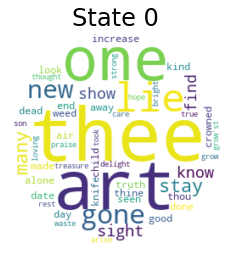

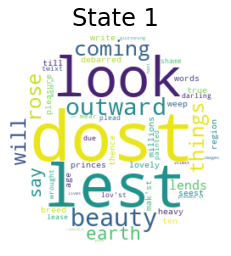

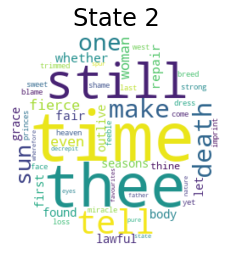

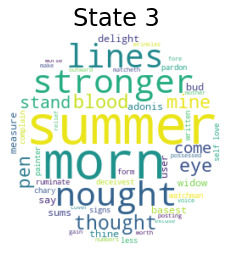

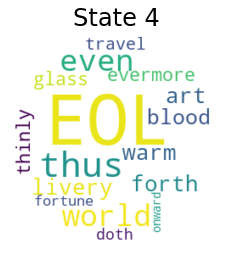

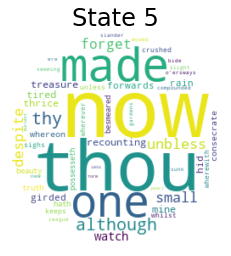

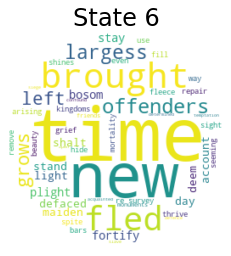

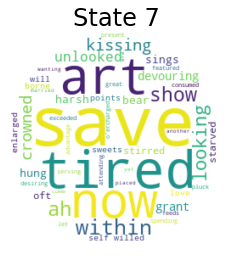

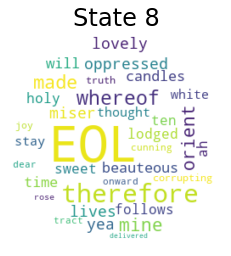

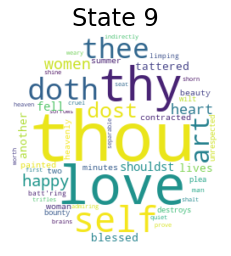

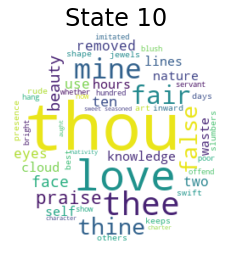

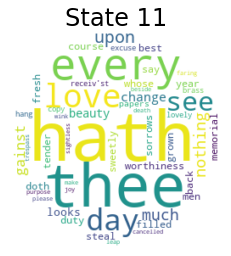

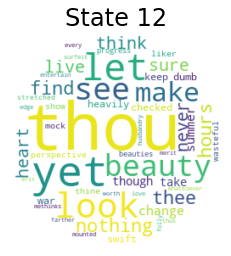

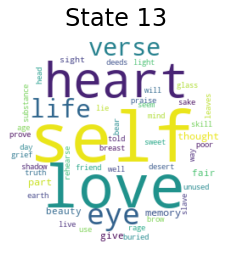

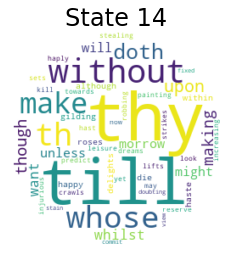

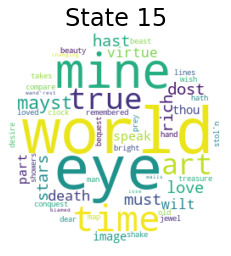

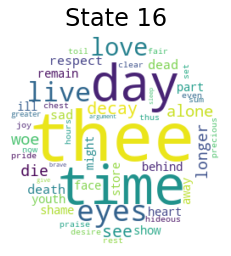

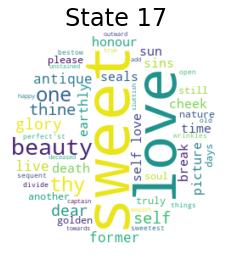

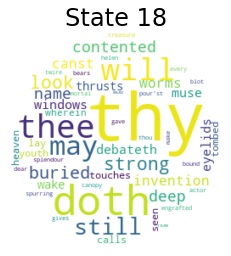

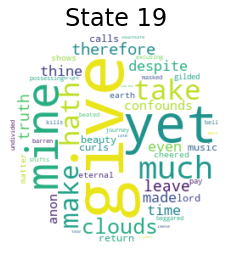

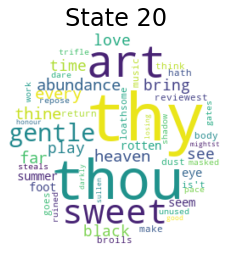

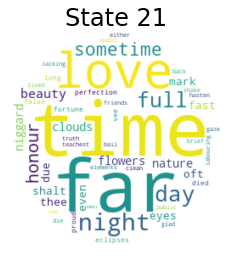

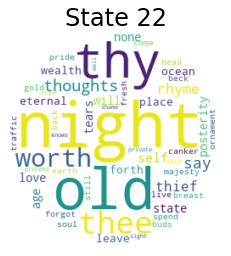

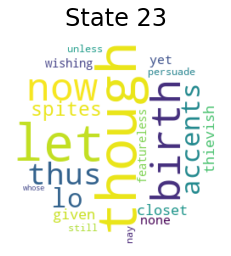

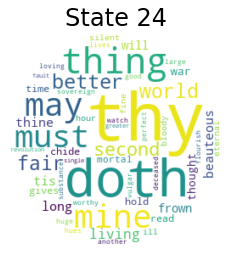

In [ ]:
states_to_wordclouds(HMM,obs_map_r)

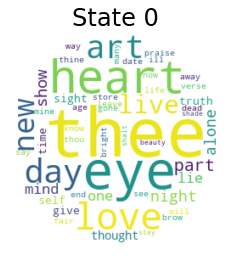

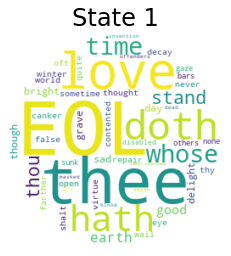

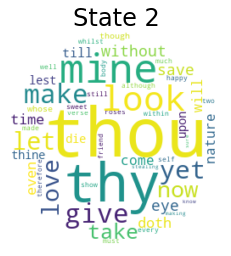

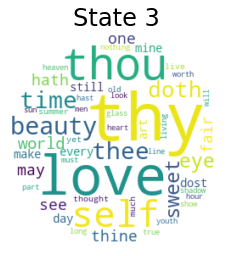

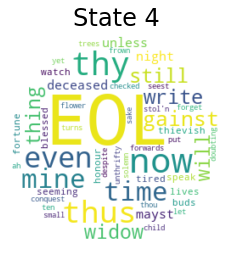

In [ ]:
states_to_wordclouds(HMM_5,obs_map_r)

In [ ]:
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()

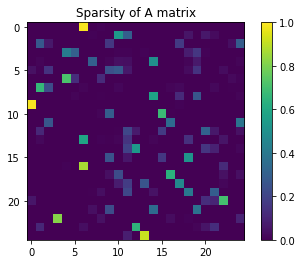

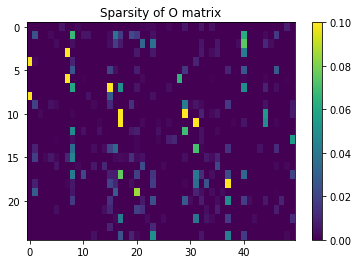

In [ ]:
visualize_sparsities(HMM)

In [ ]:
HMM.A

[[1.5188869693153685e-130,
  3.135178609182888e-203,
  1.4394755196991125e-208,
  1.0866039615615323e-74,
  1.675663233270389e-93,
  9.59652453827919e-218,
  0.9917626540017865,
  3.6199285495693706e-257,
  0.008237345998213417,
  2.6515293962561497e-115,
  1.1704071181162816e-125,
  3.8957933011646403e-100,
  5.9513537190208776e-146,
  7.2920502179927084e-177,
  2.405346533876082e-194,
  1.1997889293074293e-129,
  2.6078103502356094e-135,
  1.1765749058186099e-201,
  7.846997114596762e-128,
  1.7291414099453614e-142,
  1.8763734816865248e-222,
  2.561419836966984e-139,
  5.290573915090254e-193,
  0.0,
  7.580507537367009e-153],
 [1.2491332023943213e-79,
  9.365497746990942e-41,
  1.2018344680693088e-86,
  1.3043850446876417e-207,
  1.0751656238689767e-262,
  3.240846735711072e-44,
  8.048182128361809e-232,
  0.00871089263191934,
  3.724264991906406e-147,
  8.750199719613338e-25,
  0.5367787375472688,
  0.29918048233497485,
  8.70708989370257e-56,
  1.772782432104685e-104,
  4.49296363

In [ ]:
HMM_5.A

[[0.0066933445532087275,
  0.9853843737960714,
  7.147322821830237e-39,
  1.0806595694533366e-34,
  0.007922281650724654],
 [0.03199899468176004,
  0.001592538085247215,
  0.010173784241804242,
  0.0011027540449060017,
  0.9551319289462784],
 [0.12112080703444163,
  0.09324697672592323,
  2.43644503393769e-09,
  0.7856322138031964,
  4.9026644150953075e-85],
 [0.34131012564697344,
  0.012321471818572148,
  1.727046843507498e-18,
  0.6463684025344537,
  1.8113526506931827e-30],
 [4.773560136214171e-23,
  0.00433443440184507,
  0.9956655655981549,
  1.8659775447684343e-22,
  4.360837028678421e-65]]

In [ ]:
def animate_emission(hmm, obs_map_r, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    wordclouds = states_to_wordclouds(hmm, obs_map_r, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)


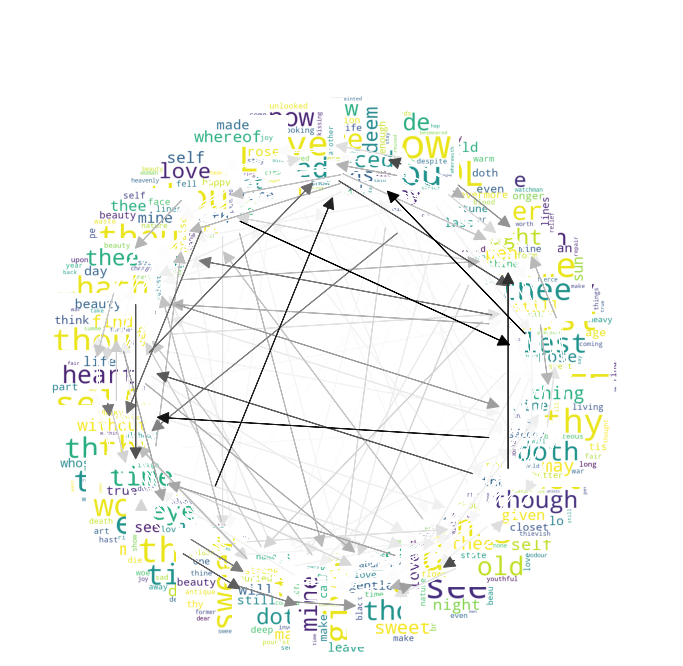

In [ ]:
animate_emission(HMM, obs_map_r)

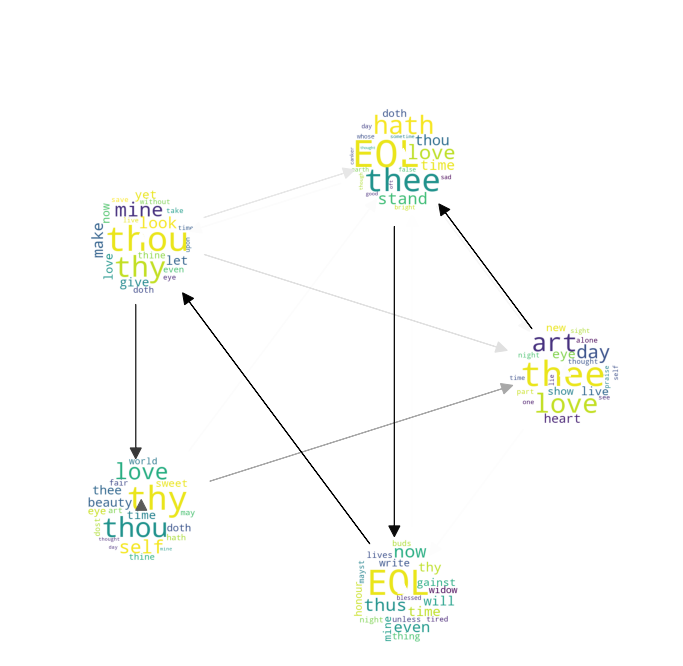

In [ ]:
animate_emission(HMM_5, obs_map_r)